# MinMod Knowledge Graph

### live at [https://minmod.isi.edu/](https://minmod.isi.edu/) wrapping a [SPARQL Endpoint](https://minmod.isi.edu/sparql).

MinMod is the mineral data **Knowledge Graph (KG)**, integrating heterogeneous data sources including: grade-tonnage data extracted from **mine reports**, **scholarly articles**, **mine site databases**, and **structured tables** to provide a rich, queryable graph of mineral site information, and **links** to additional knowledge bases such as [GeoKB](https://geokb.wikibase.cloud/).

### data in this knowledge graph adhere to this [schema](https://github.com/DARPA-CRITICALMAAS/schemas/blob/main/ta2/README.md).

## Why KGs?

<img src="demo_imgs/minmod_kg.png" alt="minmod kg" width="250"/>

- KGs
  - graphs are natural way to **encode data**
  - KGs use **semantic concepts & relationships** to create a **Semantic Network**
  - involves **spatial & temporal** information
- RDF
  - framework within the **Semantic Web** stack
  - an extension of WWW, enabling the Web of Data (aka **"Linked Data"**)
  - Linked Open Data & **FAIR** data principles

## Constructing the KG

- Extracted data --> `JSON-LD` readers / `TTL` triples reader
- Predefined data
  - Open set of commodity entities (based on MRDS/GeoKB)
  - Finite set of deposit type entities
  - Ontology following schema to enforce class & property constraints

<img src="demo_imgs/minmod_pipeline.png" alt="minmod kg" width="600"/>

## Interacting with the KG
MinMod KG `SPARQL` Sandbox

In [56]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import geopandas as gpd
import contextily as ctx
from shapely import wkt
from shapely.wkt import loads
from shapely.errors import WKTReadingError
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()

In [57]:
def safe_wkt_load(wkt_string):
    try:
        return loads(wkt_string)
    except WKTReadingError as e:
        print(f"Error converting WKT: {e}")
        return None

In [5]:
def run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=False):
    # add prefixes
    final_query = '''
    PREFIX dcterms: <http://purl.org/dc/terms/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX : <https://minmod.isi.edu/resource/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX gkbi: <https://geokb.wikibase.cloud/entity/>
    PREFIX gkbp: <https://geokb.wikibase.cloud/wiki/Property:>
    PREFIX gkbt: <https://geokb.wikibase.cloud/prop/direct/>
    PREFIX geo: <http://www.opengis.net/ont/geosparql#>
    \n''' + query
    # send query
    response = requests.post(
        url=endpoint,
        data={'query': final_query},
        headers={
            "Content-Type": "application/x-www-form-urlencoded",
            "Accept": "application/sparql-results+json"  # Requesting JSON format
        },
        verify=False  # Set to False to bypass SSL verification as per the '-k' in curl
    )
    #print(response.text)
    try:
        qres = response.json()
        if "results" in qres and "bindings" in qres["results"]:
            df = pd.json_normalize(qres['results']['bindings'])
            if values:
                filtered_columns = df.filter(like='.value').columns
                df = df[filtered_columns]
            return df
    except:
        return None

In [6]:
def run_minmod_query(query, values=False):
    return run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=values)

def run_geokb_query(query, values=False):
    return run_sparql_query(query, endpoint='https://geokb.wikibase.cloud/query/sparql', values=values)

--------------------------------------------------------

In [38]:
pd.set_option('display.max_rows', 20)

### 0. Count total number of triples in KG

In [51]:
query = ''' SELECT (COUNT(?s) as ?count)
            WHERE {
                ?s ?p ?o .
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,2903193


### 1. Deposit Types

In [65]:
query = ''' SELECT ?ci ?cn ?cg ?ce
            WHERE {
                ?ci a :DepositType .
                ?ci rdfs:label ?cn .
                ?ci :deposit_group ?cg .
                ?ci :environment ?ce .
            } '''
run_minmod_query(query, values=True)

,ci.value,cn.value,cg.value,ce.value
0,https://minmod.isi.edu/resource/Q366,Sedimentary manganese,Manganese,Basin chemical
1,https://minmod.isi.edu/resource/Q362,Superior-type banded iron formation,Iron formation,Basin chemical
2,https://minmod.isi.edu/resource/Q400,Iron sulfide polymetallic,Metasomatic iron,Regional metasomatic
3,https://minmod.isi.edu/resource/Q457,Climax-type porphyry molybdenum,Porphyry,Magmatic hydrothermal
4,https://minmod.isi.edu/resource/Q345,Lacustrine evaporite trona,Evaporite,Basin evaporative
...,...,...,...,...
184,https://minmod.isi.edu/resource/Q343,Marine evaporite potash,Evaporite,Basin evaporative
185,https://minmod.isi.edu/resource/Q301,Residual placer tin,Placer,Erosional
186,https://minmod.isi.edu/resource/Q330,Supergene zinc,Supergene,Supergene
187,https://minmod.isi.edu/resource/Q379,Kipushi-type sediment- hosted copper- zinc-lead,Sediment-hosted,Basin hydrothermal


### 2. Mineral Inventories

#### 2.1. **Zinc** Ore values, from all inventories, their grades, & cutoff grades, for inventories with grade >= 12

In [66]:
query = ''' SELECT ?o_inv ?comm_name ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Zinc"@en ] .
                
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
                FILTER (?grade >= 12)
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,1340000,16.8,10,https://minmod.isi.edu/resource/inferred
1,https://minmod.isi.edu/resource/httpsw3idorgus...,574365,12.56,5,https://minmod.isi.edu/resource/measured
2,https://minmod.isi.edu/resource/httpsw3idorgus...,822000,18.9,10,https://minmod.isi.edu/resource/indicated
3,https://minmod.isi.edu/resource/httpsw3idorgus...,1313000,13.2,8,https://minmod.isi.edu/resource/Measured
4,https://minmod.isi.edu/resource/httpsw3idorgus...,574582,12.56,5,https://minmod.isi.edu/resource/Measured
...,...,...,...,...,...
8631,https://minmod.isi.edu/resource/httpsw3idorgus...,21400,14.26,4.5,https://minmod.isi.edu/resource/inferred
8632,https://minmod.isi.edu/resource/httpsw3idorgus...,21400,14.26,10.5,https://minmod.isi.edu/resource/inferred
8633,https://minmod.isi.edu/resource/httpsw3idorgus...,21400,14.26,6.5,https://minmod.isi.edu/resource/inferred
8634,https://minmod.isi.edu/resource/httpsw3idorgus...,21400,14.26,14,https://minmod.isi.edu/resource/inferred


#### 2.2. **Nickel** Ore values, from all inventories, their grades & cutoff grades

In [67]:
query = ''' SELECT ?o_inv ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Nickel"@en ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.12,0.9,https://minmod.isi.edu/resource/inferred
1,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.12,0.9,https://minmod.isi.edu/resource/inferred
2,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.12,0.9,https://minmod.isi.edu/resource/inferred
3,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,1.12,0.9,https://minmod.isi.edu/resource/inferred
4,https://minmod.isi.edu/resource/httpsw3idorgus...,3119000,5.25,0.9,https://minmod.isi.edu/resource/inferred
...,...,...,...,...,...
1864,https://minmod.isi.edu/resource/httpsw3idorgus...,2705000,1.58,0.83,https://minmod.isi.edu/resource/inferred
1865,https://minmod.isi.edu/resource/httpsw3idorgus...,2705000,0.95,0.83,https://minmod.isi.edu/resource/inferred
1866,https://minmod.isi.edu/resource/httpsw3idorgus...,2705000,0.95,0.83,https://minmod.isi.edu/resource/inferred
1867,https://minmod.isi.edu/resource/httpsw3idorgus...,2705000,0.95,0.83,https://minmod.isi.edu/resource/inferred


### 3. Commodities

#### 3.1. all commodities and their `GeoKB` URIs

In [68]:
query = ''' SELECT ?ci ?cn ?gi
            WHERE {
                ?ci a :Commodity .
                ?ci :name ?cn .
                ?ci owl:sameAs ?gi .
            } '''
example_df = run_minmod_query(query)
example_df

,ci.type,ci.value,cn.type,cn.xml:lang,cn.value,gi.type,gi.value
0,uri,https://minmod.isi.edu/resource/Q563,literal,en,"Iron, Pyrite",uri,https://geokb.wikibase.cloud/entity/Q448
1,uri,https://minmod.isi.edu/resource/Q515,literal,en,Boron-Borates,uri,https://geokb.wikibase.cloud/entity/Q418
2,uri,https://minmod.isi.edu/resource/Q574,literal,en,Mica,uri,https://geokb.wikibase.cloud/entity/Q476
3,uri,https://minmod.isi.edu/resource/Q541,literal,en,Dolomite,uri,https://geokb.wikibase.cloud/entity/Q444
4,uri,https://minmod.isi.edu/resource/Q565,literal,en,Lead,uri,https://geokb.wikibase.cloud/entity/Q342
...,...,...,...,...,...,...,...
84,uri,https://minmod.isi.edu/resource/Q544,literal,en,Gemstone,uri,https://geokb.wikibase.cloud/entity/Q452
85,uri,https://minmod.isi.edu/resource/Q568,literal,en,"Limestone, Ultra Pure",uri,https://geokb.wikibase.cloud/entity/Q471
86,uri,https://minmod.isi.edu/resource/Q535,literal,en,"Coal, Lignite",uri,https://geokb.wikibase.cloud/entity/Q438
87,uri,https://minmod.isi.edu/resource/Q516,literal,en,Cadmium,uri,https://geokb.wikibase.cloud/entity/Q306


#### 3.2. get commodity symboles from `GeoKB`

In [ ]:
def get_symbol_via_sparql(geokb_uri):
    query = '''
    SELECT ?symb
    WHERE {
        <%s> gkbt:P17 ?symb .
    }''' % (geokb_uri)
    result_record = run_geokb_query(query)
    if len(result_record) > 0:
        return result_record.iloc[0]['symb.value']
    return ""

In [ ]:
#pd.set_option('display.max_rows', 500)

example_df['geoKB Symbol'] = example_df['gi.value'].progress_apply(get_symbol_via_sparql)
example_df

### 4. Mineral Sites

#### 4.1. all Nickel `MineralSite` instances

In [48]:
query = ''' SELECT ?ms ?msr ?mss ?loc_wkt
            WHERE {
                ?ms a :MineralSite .
                ?ms :record_id ?msr .
                ?ms :source_id ?mss .
                ?ms :location_info [ :location ?loc_wkt ] .
                
                ?ms :mineral_inventory ?mi .
                ?mi :commodity [ :name "Nickel"@en ] .
            } '''
df_2 = run_minmod_query(query, values=True)
df_2

,ms.value,msr.value,mss.value,loc_wkt.value
0,https://minmod.isi.edu/resource/site__spruce-r...,Spruce Road,Mudd-and-Jowitt-2022-Nickel/AR 2018,POINT (-91.7 47.83)
1,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury-Victoria (KGHM),Mudd-and-Jowitt-2022-Nickel/KGHM Presentation ...,POINT (-81.38751 46.42380)
2,https://minmod.isi.edu/resource/httpsw3idorgus...,1,https://w3id.org/usgs/z/4530692/XM7ACJDK,POINT(-93.1 46.683)
3,https://minmod.isi.edu/resource/httpsw3idorgus...,1,https://w3id.org/usgs/z/4530692/26ZXZM5R,POINT(-88.933333 48.75)
4,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury Group (Vale),Mudd-and-Jowitt-2022-Nickel/Form 20F 2018,POINT (-81.06776 46.49230)
...,...,...,...,...
96,https://minmod.isi.edu/resource/site__riddle-n...,Riddle (Nickel Mountain),Mudd-and-Jowitt-2022-Nickel/Berger et al (2011),POINT (-123.437 42.966)
97,https://minmod.isi.edu/resource/site__northmet...,NorthMet (Dunka Road),Mudd-and-Jowitt-2022-Nickel/AIF 2018,POINT (-92 47.6)
98,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury-West Graham,Mudd-and-Jowitt-2022-Nickel/Tech Rep (2018-01),POINT (-81.31286 46.41797)
99,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury-Podolsky (KGHM),Mudd-and-Jowitt-2022-Nickel/AIF 2010,POINT (-80.87570 46.77810)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 47507.54it/s]


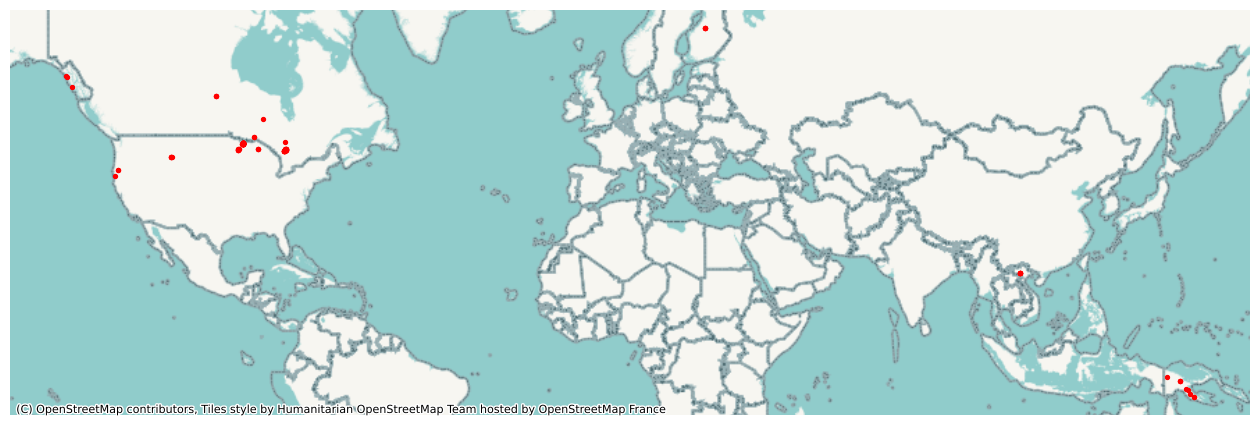

In [49]:
df_2['loc_wkt'] = df_2['loc_wkt.value'].progress_apply(safe_wkt_load)

sample_gdf = gpd.GeoDataFrame(df_2, geometry='loc_wkt', crs='epsg:4326')
# WGS84 (EPSG:4326) to Web Mercator (EPSG:3857).
sample_gdf = sample_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(16, 16))
sample_gdf.plot(ax=ax, color='red', markersize=8)
ax.set_axis_off()
ctx.add_basemap(ax)
plt.show()

### 5. Grade-Tonnage models

In [52]:
# todo: use grade-units to convert to single unit/format
# todo: use ore-units to convert to single unit/format
# todo: final resource estimate

query_template = '''
SELECT ?mineralInventory ?cont_metal ?tonnage  ?grade ?category
WHERE {
    ?mineralInventory a            :MineralInventory .
    
    ?mineralInventory :ore         ?ore .
    ?ore              :ore_value   ?tonnage .
    
    ?mineralInventory :grade       ?gradeInfo .
    ?gradeInfo        :grade_value ?grade .

    ?mineralInventory :contained_metal ?cont_metal .
    
    ?mineralInventory :commodity   ?Commodity .
    ?Commodity        :name        "%s"@en .

    ?mineralInventory :category    ?category .
}
'''

In [53]:
query_resp_df = run_minmod_query(query_template % "Zinc", values=True)
mineral_data_df = pd.DataFrame([
    {
        'name': row['mineralInventory.value'].split('/')[-1],  # This is not really the name, it's the suffix of the uri
        'contained_metal': float(row['cont_metal.value']),
        'tonnage': float(row['tonnage.value']),
        'grade': float(row['grade.value']),
        'category': row['category.value'].split('/')[-1]
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

,name,contained_metal,tonnage,grade,category
0,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,499496.00,9.63,Indicated
1,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,499496.00,9.65,Indicated
2,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,501555.00,9.63,Indicated
3,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,501555.00,9.65,Indicated
4,httpsw3idorgusgsz453069288w9puz91-httpsw3idorg...,565500.0000,72.50,0.78,probable
...,...,...,...,...,...
1265,httpsw3idorgusgsz45306925sv8ibcw1-httpsw3idorg...,79.9558,150.86,0.53,indicated
1266,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,14788000.00,1.70,indicated
1267,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,14788000.00,1.37,indicated
1268,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,2088000.00,1.70,indicated


In [54]:
query_resp_df = run_minmod_query(query_template % "Nickel", values=True)
mineral_data_df = pd.DataFrame([
    {
        'name': row['mineralInventory.value'].split('/')[-1],  # This is not really the name, it's the suffix of the uri
        'contained_metal': float(row['cont_metal.value']),
        'tonnage': float(row['tonnage.value']),
        'grade': float(row['grade.value']),
        'category': row['category.value'].split('/')[-1]
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

,name,contained_metal,tonnage,grade,category
0,httpsw3idorgusgsz4530692xm7acjdk1-httpsw3idorg...,10628800.0,949000.0,0.95,inferred
1,httpsw3idorgusgsz4530692xm7acjdk1-httpsw3idorg...,10628800.0,949000.0,5.25,inferred
2,httpsw3idorgusgsz4530692xm7acjdk1-httpsw3idorg...,10628800.0,949000.0,1.22,inferred
3,httpsw3idorgusgsz4530692xm7acjdk1-httpsw3idorg...,10628800.0,949000.0,1.12,inferred
4,httpsw3idorgusgsz4530692xm7acjdk1-httpsw3idorg...,10628800.0,3119000.0,0.95,inferred
...,...,...,...,...,...
334,httpsw3idorgusgsz45306924j6vp5m91-httpsw3idorg...,168840.0,89000.0,0.67,inferred
335,httpsw3idorgusgsz45306924j6vp5m91-httpsw3idorg...,168840.0,89000.0,0.72,inferred
336,httpsw3idorgusgsz45306924j6vp5m91-httpsw3idorg...,168840.0,89000.0,0.55,inferred
337,httpsw3idorgusgsz4530692487ftniz1-httpsw3idorg...,95400.0,53000.0,0.18,inferred


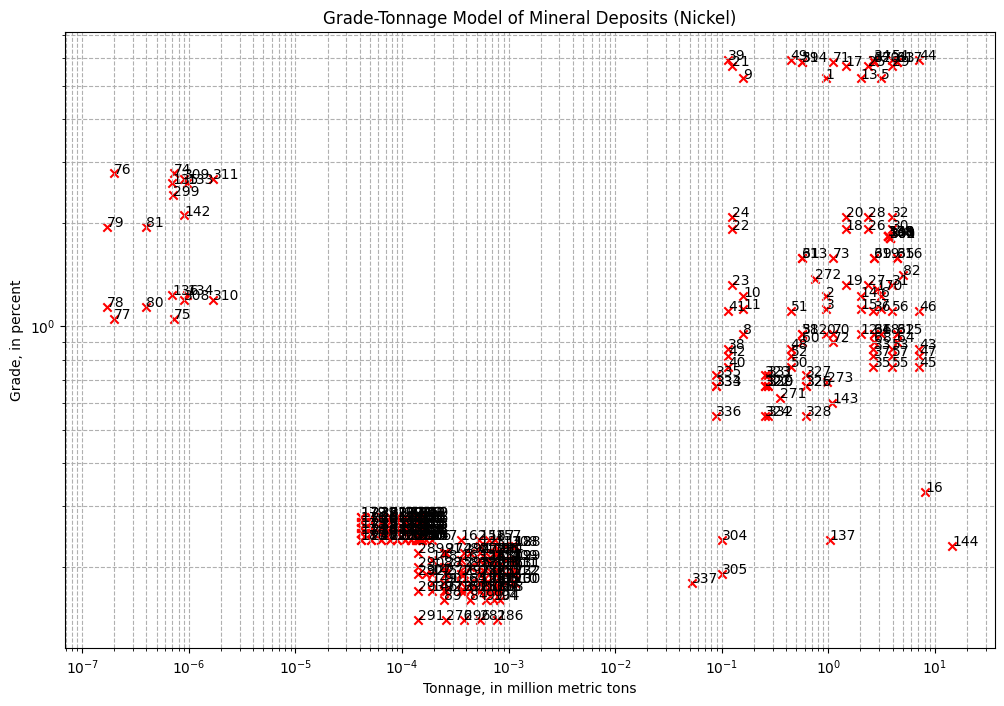

In [55]:
tonnages = mineral_data_df['tonnage'].values
grades = mineral_data_df['grade'].values
names = mineral_data_df.index.values # mineral_data_df['name'].values

# todo: convert tonnage to million metric tons using unit-transformation
tonnages_million_metric_tons = tonnages / 1e6

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tonnages_million_metric_tons, grades, marker='x', color='r')

# loga scale
plt.xscale('log')
plt.yscale('log')

# todo: units should be evaluated and converted
plt.xlabel('Tonnage, in million metric tons')
plt.ylabel('Grade, in percent')
plt.title('Grade-Tonnage Model of Mineral Deposits (Nickel)')

plt.grid(True, which="both", ls="--")
for i, txt in enumerate(names):
    plt.annotate(txt, (tonnages_million_metric_tons[i], grades[i]))
plt.show()

### 6. More coordinate data

In [58]:
query = '''
SELECT ?site ?loc ?tonnage ?grade
WHERE {
  ?site a :MineralSite .
  ?site :mineral_inventory ?inv .

  ?inv :commodity [ :name "Nickel"@en ] .
  ?inv :category  :Indicated .
  ?inv :ore       [ :ore_value   ?tonnage ] .
  ?inv :grade     [ :grade_value ?grade ] .
  
  ?site:location_info [ :location ?loc ] .
  FILTER(datatype(?loc) = geo:wktLiteral)
}
'''
loc_df = run_minmod_query(query, values=True)
loc_df['loc_wkt'] = loc_df['loc.value'].progress_apply(safe_wkt_load)
loc_df.dropna(inplace=True)
loc_df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 7626.78it/s]


,site.value,loc.value,tonnage.value,grade.value,loc_wkt
0,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-81.06776 46.49230),40.8,1.27,POINT (-81.06776 46.4923)
1,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.87806 46.80500),0.264,0.65,POINT (-80.87806 46.805)
2,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-81.38751 46.42380),9.741,0.63,POINT (-81.38751 46.4238)
3,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-81.13276 46.74104),1.56,0.94,POINT (-81.13276 46.74104)
4,https://minmod.isi.edu/resource/site__ramu__mu...,POINT (145.20393 -5.57077),42.0,0.9,POINT (145.20393 -5.57077)
5,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.79985 46.58103),23.25,2.1,POINT (-80.79985 46.58103)
6,https://minmod.isi.edu/resource/site__maturi-i...,POINT (-91.8 47.8),818.3,0.18,POINT (-91.8 47.8)
7,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.89786 46.56702),0.56,1.17,POINT (-80.89786 46.56702)
8,https://minmod.isi.edu/resource/site__sudbury-...,POINT (-80.87570 46.77810),6.7,0.72,POINT (-80.8757 46.7781)
9,https://minmod.isi.edu/resource/site__stillwat...,POINT (-109.9 45.39),55.4,0.1,POINT (-109.9 45.39)


## Deposit Type Classification

### Retrieve all deposit classifications

In [7]:
query = '''
SELECT ?ms ?dt_conf ?dt_s ?dt_on ?cn ?cg ?ce ?country
WHERE {
  ?ms a :MineralSite .

  ?ms :location_info [ :country ?country ] .
  #?ms :location_info [ :location ?loc ] .
  #FILTER(datatype(?loc) = geo:wktLiteral)
  
  #?ms :mineral_inventory ?mi .
  #?mi :commodity [ :name "Nickel"@en ] .
  
  ?ms :deposit_type_candidate ?dpc .
  
  ?dpc :confidence ?dt_conf .
  ?dpc :observed_name ?dt_on .
  ?dpc :source ?dt_s .
  
  OPTIONAL { ?dpc :normalized_uri [
      rdfs:label ?cn;
      :deposit_group ?cg;
      :environment ?ce ] }
}
'''
tmp_df = run_minmod_query(query, values=True)
tmp_df

,ms.value,dt_conf.value,dt_s.value,dt_on.value,cn.value,cg.value,ce.value,country.value
0,https://minmod.isi.edu/resource/mrds10183827,0.0327790342271328,"algorithm predictions, SRI deposit type classi...",Porphyry tungsten,Porphyry tungsten,Porphyry,Magmatic hydrothermal,Spain
1,https://minmod.isi.edu/resource/mrds10183827,0.02389947883784771,"algorithm predictions, SRI deposit type classi...",Fluvial placer tungsten,Fluvial placer tungsten,Placer,Erosional,Spain
2,https://minmod.isi.edu/resource/mrds10183827,0.029485883191227913,"algorithm predictions, SRI deposit type classi...",Vein tungsten,Vein tungsten,Vein,Magmatic hydrothermal,Spain
3,https://minmod.isi.edu/resource/mrds10183827,0.015555216930806637,"algorithm predictions, SRI deposit type classi...",Skarn tungsten ± Mo,Skarn tungsten ± Mo,Skarn,Magmatic hydrothermal,Spain
4,https://minmod.isi.edu/resource/mrds10183827,0.016497410833835602,"algorithm predictions, SRI deposit type classi...",Greisen tungsten- molybdenum±Bi,Greisen tungsten- molybdenum±Bi,Greisen,Magmatic hydrothermal,Spain
...,...,...,...,...,...,...,...,...
118639,https://minmod.isi.edu/resource/mrds10307429,0.037319548428058624,"algorithm predictions, SRI deposit type classi...",Supergene lead,Supergene lead,Supergene,Supergene,United States
118640,https://minmod.isi.edu/resource/mrds10307429,0.026404917240142822,"algorithm predictions, SRI deposit type classi...",Non-sulfide zinc-lead ± Mn,Non-sulfide zinc-lead ± Mn,Non-sulfide,Basin hydrothermal,United States
118641,https://minmod.isi.edu/resource/mrds10307429,0.02521389164030552,"algorithm predictions, SRI deposit type classi...",Siliciclastic-mafic zinc-lead,Siliciclastic-mafic zinc-lead,Sediment-hosted,Basin hydrothermal,United States
118642,https://minmod.isi.edu/resource/mrds10307429,0.024124963209033012,"algorithm predictions, SRI deposit type classi...",Siliciclastic- carbonate zinc-lead,Siliciclastic- carbonate zinc-lead,Sediment-hosted,Basin hydrothermal,United States


In [56]:
nickel_dc_data_df = pd.DataFrame([
    {
        'url': row['ms.value'], # navigable
        'confidence': row['dt_conf.value'],
        'source': row['dt_s.value'],
        'observed_deposit_name': row['dt_on.value'],
        'deposit_name': row['cn.value'],
        'deposit_group': row['cg.value'],
        'deposit_environment': row['ce.value'],
        'country': row['country.value']
    }
    for index, row in tmp_df.iterrows()
])
nickel_dc_data_df

,url,confidence,source,observed_deposit_name,deposit_name,deposit_group,deposit_environment,country
0,https://minmod.isi.edu/resource/mrds10183827,0.0327790342271328,"algorithm predictions, SRI deposit type classi...",Porphyry tungsten,Porphyry tungsten,Porphyry,Magmatic hydrothermal,Spain
1,https://minmod.isi.edu/resource/mrds10183827,0.029485883191227913,"algorithm predictions, SRI deposit type classi...",Vein tungsten,Vein tungsten,Vein,Magmatic hydrothermal,Spain
2,https://minmod.isi.edu/resource/mrds10183827,0.02389947883784771,"algorithm predictions, SRI deposit type classi...",Fluvial placer tungsten,Fluvial placer tungsten,Placer,Erosional,Spain
3,https://minmod.isi.edu/resource/mrds10183827,0.016497410833835602,"algorithm predictions, SRI deposit type classi...",Greisen tungsten- molybdenum±Bi,Greisen tungsten- molybdenum±Bi,Greisen,Magmatic hydrothermal,Spain
4,https://minmod.isi.edu/resource/mrds10183827,0.015555216930806637,"algorithm predictions, SRI deposit type classi...",Skarn tungsten ± Mo,Skarn tungsten ± Mo,Skarn,Magmatic hydrothermal,Spain
...,...,...,...,...,...,...,...,...
104588,https://minmod.isi.edu/resource/mrds10307429,0.026404917240142822,"algorithm predictions, SRI deposit type classi...",Non-sulfide zinc-lead ± Mn,Non-sulfide zinc-lead ± Mn,Non-sulfide,Basin hydrothermal,United States
104589,https://minmod.isi.edu/resource/mrds10307429,0.037319548428058624,"algorithm predictions, SRI deposit type classi...",Supergene lead,Supergene lead,Supergene,Supergene,United States
104590,https://minmod.isi.edu/resource/mrds10307429,0.02521389164030552,"algorithm predictions, SRI deposit type classi...",Siliciclastic-mafic zinc-lead,Siliciclastic-mafic zinc-lead,Sediment-hosted,Basin hydrothermal,United States
104591,https://minmod.isi.edu/resource/mrds10307429,0.024124963209033012,"algorithm predictions, SRI deposit type classi...",Siliciclastic- carbonate zinc-lead,Siliciclastic- carbonate zinc-lead,Sediment-hosted,Basin hydrothermal,United States


In [57]:
nickel_dc_data_df['source'].value_counts()

source
algorithm predictions, SRI deposit type classification, v0b, 20240213    102900
sand                                                                       1686
SME                                                                           7
Name: count, dtype: int64

In [58]:
nickel_dc_data_df['country'].value_counts()

country
United States    71918
Canada            4966
Australia         3101
Bolivia           2825
Russia            2737
                 ...  
Cameroon             4
Côte d'Ivoire        4
Togo                 3
Oman                 3
Guinea               3
Name: count, Length: 118, dtype: int64

In [62]:
nickel_dc_data_df[nickel_dc_data_df['country'].str.contains("United")]['country'].value_counts()

country
United States               71918
United Kingdom                 95
United States of America        6
Name: count, dtype: int64

In [63]:
nickel_dc_data_df[nickel_dc_data_df['country'].str.contains("United States")]

,url,confidence,source,observed_deposit_name,deposit_name,deposit_group,deposit_environment,country
10,https://minmod.isi.edu/resource/mrds10111819,0.016684068366885185,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion PGE,U-M layered intrusion PGE,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
11,https://minmod.isi.edu/resource/mrds10111819,0.02597236260771751,"algorithm predictions, SRI deposit type classi...",Ophiolite chromium,Ophiolite chromium,Ophiolite,Magmatic,United States
12,https://minmod.isi.edu/resource/mrds10111819,0.016139039769768715,"algorithm predictions, SRI deposit type classi...",Fluvial placer PGE,Fluvial placer PGE,Placer,Erosional,United States
13,https://minmod.isi.edu/resource/mrds10111819,0.028219912201166153,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion chromium,U-M layered intrusion chromium,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
14,https://minmod.isi.edu/resource/mrds10111819,0.02360784076154232,"algorithm predictions, SRI deposit type classi...",Mafic-ultramafic VMS,Mafic-ultramafic VMS,Volcanogenic massive sulfide (VMS),Volcanic basin hydrothermal,United States
...,...,...,...,...,...,...,...,...
104588,https://minmod.isi.edu/resource/mrds10307429,0.026404917240142822,"algorithm predictions, SRI deposit type classi...",Non-sulfide zinc-lead ± Mn,Non-sulfide zinc-lead ± Mn,Non-sulfide,Basin hydrothermal,United States
104589,https://minmod.isi.edu/resource/mrds10307429,0.037319548428058624,"algorithm predictions, SRI deposit type classi...",Supergene lead,Supergene lead,Supergene,Supergene,United States
104590,https://minmod.isi.edu/resource/mrds10307429,0.02521389164030552,"algorithm predictions, SRI deposit type classi...",Siliciclastic-mafic zinc-lead,Siliciclastic-mafic zinc-lead,Sediment-hosted,Basin hydrothermal,United States
104591,https://minmod.isi.edu/resource/mrds10307429,0.024124963209033012,"algorithm predictions, SRI deposit type classi...",Siliciclastic- carbonate zinc-lead,Siliciclastic- carbonate zinc-lead,Sediment-hosted,Basin hydrothermal,United States


In [64]:
#nickel_dc_data_df.to_csv('nickel_dc_data_df.csv')

### Consolidating Desposit Type Classification data

In [8]:
valid_deposit_Qs = ["Q478", "Q481", "Q482", "Q486", "Q488", "Q489"]
valid_deposit_Qs = ['https://minmod.isi.edu/resource/' + x for x in valid_deposit_Qs]

In [9]:
query = '''
SELECT ?ms ?oms ?dt_conf ?dt_s ?cn ?cg ?ce ?country ?dtnorm ?loc_wkt
WHERE {
  ?ms a :MineralSite .
  
  ?ms :deposit_type_candidate ?dpc .
  
  ?dpc :confidence ?dt_conf .
 # ?dpc :observed_name ?dt_on .
  ?dpc :source ?dt_s .
  OPTIONAL { ?ms owl:sameAs ?oms . }
 ?dpc :normalized_uri ?dtnorm .
      
  ?ms :location_info [ :country ?country ] .
  
  ?ms :mineral_inventory ?mi .
  ?mi :commodity [ :name "Nickel"@en ] .
  
  OPTIONAL {
      ?ms :location_info [ :location ?loc_wkt ] .
      FILTER(datatype(?loc_wkt) = geo:wktLiteral)
  }
}'''  
# print(query)

tmp_df = run_minmod_query(query, values=True)
tmp_df

,ms.value,dt_conf.value,dt_s.value,country.value,dtnorm.value,loc_wkt.value,oms.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,0.08644283562898636,"algorithm predictions, SRI deposit type classi...",United States of America,https://minmod.isi.edu/resource/Q486,POINT(-91.759305555556 47.799861111111),NaN
1,https://minmod.isi.edu/resource/httpsw3idorgus...,0.08644283562898636,"algorithm predictions, SRI deposit type classi...",United States of America,https://minmod.isi.edu/resource/Q486,POINT (-91.759305555556 47.799861111111),NaN
2,https://minmod.isi.edu/resource/httpsw3idorgus...,0.08644283562898636,"algorithm predictions, SRI deposit type classi...",United States of America,https://minmod.isi.edu/resource/Q486,POINT(-91.759305555556 47.799861111111),NaN
3,https://minmod.isi.edu/resource/httpsw3idorgus...,0.08644283562898636,"algorithm predictions, SRI deposit type classi...",United States of America,https://minmod.isi.edu/resource/Q486,POINT (-91.759305555556 47.799861111111),NaN
4,https://minmod.isi.edu/resource/httpsw3idorgus...,1e+00,expert,United States of America,https://minmod.isi.edu/resource/Q478,POINT(-91.759305555556 47.799861111111),NaN
...,...,...,...,...,...,...,...
341,https://minmod.isi.edu/resource/site__stillwat...,1e+00,expert,USA,https://minmod.isi.edu/resource/Q478,POINT (-109.9 45.39),NaN
342,https://minmod.isi.edu/resource/site__stillwat...,1e+00,expert,USA,https://minmod.isi.edu/resource/Q478,POINT (-109.9 45.39),NaN
343,https://minmod.isi.edu/resource/site__birch-la...,1e+00,expert,USA,https://minmod.isi.edu/resource/Q478,POINT (-91.8 47.75),NaN
344,https://minmod.isi.edu/resource/site__birch-la...,1e+00,expert,USA,https://minmod.isi.edu/resource/Q478,POINT (-91.8 47.75),NaN


In [10]:
filtered_tmp_df = tmp_df[tmp_df['country.value'].isin(["USA", "United States", "United States of America"])]
filtered_tmp_df = filtered_tmp_df[filtered_tmp_df['dtnorm.value'].isin(valid_deposit_Qs)]

In [11]:
from collections import defaultdict
clusterid = {}
id2rows = defaultdict(list)

for _, row in filtered_tmp_df.iterrows():
    v1 = row['ms.value']
    v2 = row['oms.value']
    if not isinstance(v2, str):
        v2 = v1
        
    if v1 not in clusterid and v2 not in clusterid:
        clusterid[v1] = len(clusterid)
        clusterid[v2] = clusterid[v1]
    elif v1 not in clusterid:
        assert v2 in clusterid
        clusterid[v1] =clusterid[v2]
    elif v2 not in clusterid:
        assert v1 in clusterid
        clusterid[v2] =clusterid[v1]
    else:
        assert clusterid[v1] == clusterid[v2]
    
    id2rows[clusterid[v1]].append(row)

In [12]:
values = []

for id, rows in id2rows.items():
    if len(rows) == 1:
        values.append(rows[0])
    else:
        row = max(rows, key=lambda r: r['dt_conf.value'])
        values.append(row)

In [26]:
df = pd.DataFrame(values)
len(df)

29

In [27]:
df

,ms.value,dt_conf.value,dt_s.value,country.value,dtnorm.value,loc_wkt.value,oms.value
4,https://minmod.isi.edu/resource/httpsw3idorgus...,1e+00,expert,United States of America,https://minmod.isi.edu/resource/Q478,POINT(-91.759305555556 47.799861111111),NaN
30,https://minmod.isi.edu/resource/httpsw3idorgus...,1e+00,expert,United States,https://minmod.isi.edu/resource/Q482,NaN,NaN
42,https://minmod.isi.edu/resource/site__bohemia-...,1e+00,expert,USA,https://minmod.isi.edu/resource/Q481,POINT (-136.43427 57.98471),https://minmod.isi.edu/resource/mrds10002326
43,https://minmod.isi.edu/resource/site__northmet...,1e+00,expert,USA,https://minmod.isi.edu/resource/Q478,POINT (-92 47.6),https://minmod.isi.edu/resource/mrds10082831
46,https://minmod.isi.edu/resource/site__snipe-ba...,1e+00,expert,USA,https://minmod.isi.edu/resource/Q478,POINT (-134.95753 56.42213),https://minmod.isi.edu/resource/mrds10024471
47,https://minmod.isi.edu/resource/httpsw3idorgus...,1e+00,expert,United States,https://minmod.isi.edu/resource/Q478,POINT(-93.1 46.683),https://minmod.isi.edu/resource/mrds10038429
61,https://minmod.isi.edu/resource/site__wetlegs_...,1e+00,expert,USA,https://minmod.isi.edu/resource/Q478,NaN,NaN
80,https://minmod.isi.edu/resource/httpsw3idorgus...,1e+00,expert,United States,https://minmod.isi.edu/resource/Q482,POINT(-93.10603 46.697),https://minmod.isi.edu/resource/mrds10038424
86,https://minmod.isi.edu/resource/site__nye-basi...,1e+00,expert,USA,https://minmod.isi.edu/resource/Q478,POINT (-109.8 45.37),NaN
87,https://minmod.isi.edu/resource/site__maturi-i...,1e+00,expert,USA,https://minmod.isi.edu/resource/Q478,POINT (-91.8 47.8),https://minmod.isi.edu/resource/mrds10072944


In [33]:
df = df[df['loc_wkt.value'].str.contains('POINT') == True]

In [34]:
df['loc_wkt'] = df['loc_wkt.value'].progress_apply(safe_wkt_load)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 8578.98it/s]


In [45]:
len(df)

21

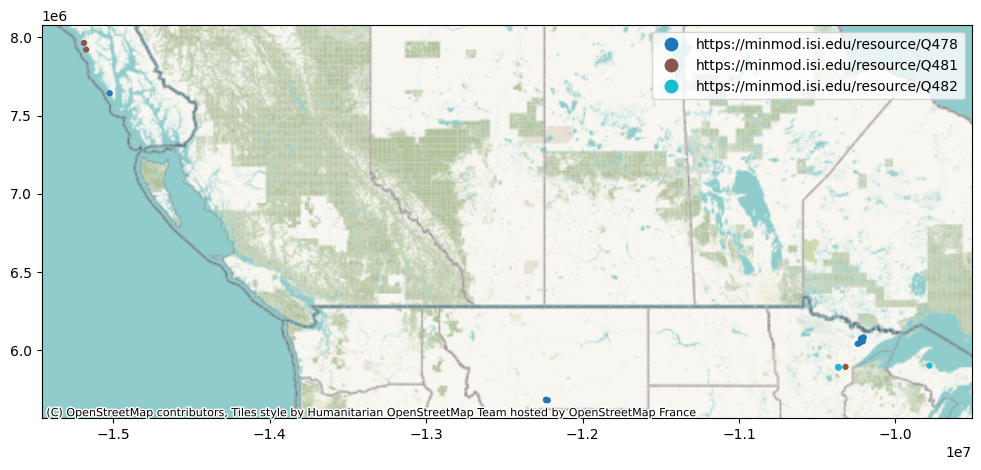

In [43]:
sample_gdf = gpd.GeoDataFrame(df, geometry='loc_wkt', crs='epsg:4326')
# WGS84 (EPSG:4326) to Web Mercator (EPSG:3857).
sample_gdf = sample_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(12, 12))
sample_gdf.plot(ax=ax, markersize=12, column='dtnorm.value', categorical=True, legend=True)
#ax.set_axis_off()
ctx.add_basemap(ax)
plt.show()